# Assignment 2, TET4565 


## Dependencies / imports


In [1]:
import pyomo.environ as pyo
import numpy as np
from pyomo.environ import ConcreteModel,Set,RangeSet,Param,Suffix,Reals,NonNegativeReals,NonPositiveReals,Binary,Objective,minimize,maximize,value
from pyomo.core import Constraint,Var,Block,ConstraintList
from pyomo.opt import SolverFactory, SolverStatus, TerminationCondition
import matplotlib.pyplot as plt
from calculations.datahandling import*
from calculations.data_processor import* 
from Optimization_modelling.generalized_two_stage import*

c:\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization\calculations\datahandling.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  irr_data = pd.read_csv(file_path, parse_dates=['time'], index_col='time', dtype=float)


## Code for data processing 

In [2]:
#Read of parameters for portfolio
data=InputData('data/Parameters.xlsx')

#Start and end dates of the optimization
start_date='2018-05-28 00:00'
end_date='2018-05-28 23:00'

#Original forecast for solar power production
Solar_p=read_solar_data('data/Data_solar_irr_NOR.csv', 'data/PV_spec.xlsx', start_date, end_date)

#Scenarios for solar forecast 
S_high=scale_dict(Solar_p, 1.5)
S_avg=scale_dict(Solar_p, 1)
S_low=scale_dict(Solar_p, 0.5)
#Load 
L= {1:30, 2:20, 3:20, 4:30, 5:50, 6:80, 7:50, 8:90, 9:110, 10:150, 11:120, 12:80, 13:70, 14:80, 15:90, 16:160, 17:170, 18:150, 19:120, 20:100, 21:70, 22:60, 23:50, 24:40}


c:\Users\oscar\OneDrive\Dokumenter\Høst 2023\TET4565 Spesialiseringsemne\Hydro_optimization\calculations\datahandling.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  irr_data = pd.read_csv(file_path, parse_dates=['time'], index_col='time', dtype=float)


## Code for defining necessary functions 

In [3]:
#Production bounds for hydro plants in stage 1
def p_bounds(model,i,j):
    return (model.Pmin[i],model.Pmax[i])
#Production constraint for hydro1 in stage 2
def hydro1_bounds(model,s,j):
    return model.p_s1[s,j]<=40
#Production constraint for hydro2 in stage 2

def hydro2_bounds(model,s,j):
    return model.p_s2[s,j]<=100
#Solar production in stage 1 must be equal to original forecast
def Solar_rule(model,j):
    return  model.phi['Solar',j] == Solar_p[j]
#Solar production in stage 2 must be equal to scenario for high production
def Solar_high(model,j):
    if model.probs['S_high']>0:
        return model.phi_s['S_high',j]==S_high[j]
    else:
        return model.phi_s['S_high',j]==0
#Solar production in stage 2 must be equal to scenario for average production
def Solar_avg(model,j):
    if model.probs['S_avg']>0:
        return  model.phi_s['S_avg',j] == S_avg[j]
    else:
        return  model.phi_s['S_avg',j] == 0
#Solar production in stage 2 must be equal to scenario for low production
def Solar_low(model,j):
    if model.probs['S_low']>0:
        return  model.phi_s['S_low',j] == S_low[j]
    else:
        return  model.phi_s['S_low',j] == 0
#Sum of hydro production in stage 1 must be lower than available generation
def Hydro_firststage(model,i):
    return sum(model.p['Hydro1',j] + model.p['Hydro2',j] for j in model.periods)<=model.Hmax[i]
#Sum of hydro production in stage 2 must be lower than capacity and the already used power in stage 1
def Hydro_secondstage(model,s,i):
    return sum(model.p_s1[s,j] +model.p_s2[s,j] for j in model.periods)<=model.Hmax[i]-sum(model.p['Hydro1',j] + model.p['Hydro2',j] for j in model.periods)
#Total power generation in stage 1 must be equal to the hourly set load
def load_rule_FirstStage(model, j):
    return model.p['Hydro1', j] + model.p['Hydro2', j] + model.phi['Solar', j] + model.L_p['Load_penalty', j] == L[j]
#Total power generation in stage 2 must be equal to the hourly set load
def load_rule_TwoStage(model, s, j):
    return model.p_s1[s,j] +model.p_s2[s,j]+ model.phi_s[s, j] + model.L_p_s[s, j] == L[j]

#Objective function 
def ObjRule(model):
    #Sum of production costs in stage 1 
    first_stage_obj = sum(model.yi[i] * model.p[i, j] for i in model.plants for j in model.periods) \
        + sum(model.ki[s] * model.phi[s, j] for s in model.solar for j in model.periods) \
        + sum(model.Li[n] * model.L_p[n, j] for n in model.penalty for j in model.periods)

    # Second stage objective (scenario-dependent), sum of all production costs
    second_stage_obj = sum(model.probs[l] * (
        model.yi[i]*(model.p_s1[l,j]+model.p_s2[l,j]) + model.ki[s] * model.phi_s[l, j] + model.Li[n] * model.L_p_s[l, j]
        ) for i in model.plants for s in model.solar for l in model.scenarios for n in model.penalty for j in model.periods)

    # Total objective is the sum of first and second stage objectives
    return first_stage_obj + second_stage_obj

## Variant 1 (Expected value of all scenarios/ base case)

source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 344 rows, 384 columns and 1296 nonzeros
Model fingerprint: 0x7d795da2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [4e+01, 1e+02]
  RHS range        [2e-01, 3e+03]
Presolve removed 340 rows and 372 columns
Presolve time: 0.01s
Presolved: 4 rows, 12 columns, 12 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.6213227e+04   3.786153e+01   0.000000e+00      0s
       4    5.9242149e+04   0.000000e+00   0.000000e+00      0s

Solved in 4 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.924214880e+04
Model unknown

  Variables:
    p : Size=48, Index=p_index
        Key            : Lower : Value     

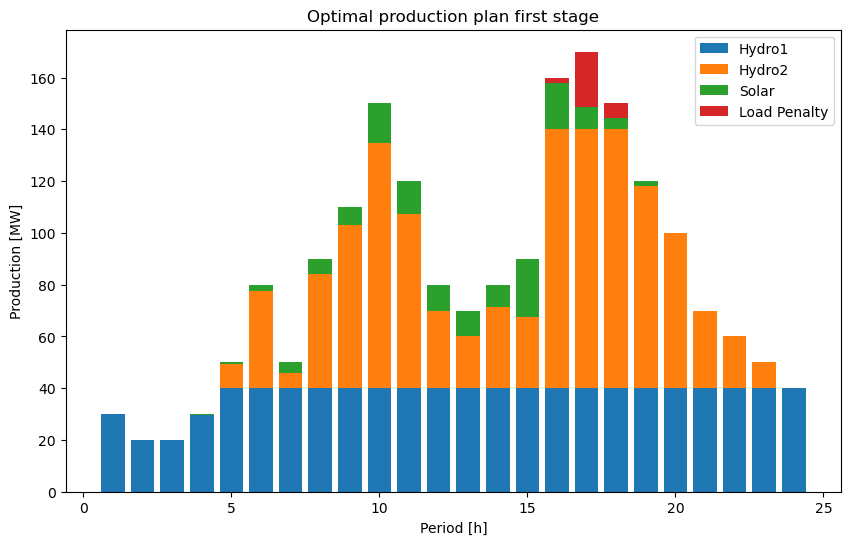

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [4]:
Constants1= {
    'Load_penalty':100, 
    'Hydro_cap':3000,
    'Scenarios':['S_high', 'S_avg', 'S_low'], 
    'probs':{'S_high':0, 'S_avg':0, 'S_low':0}     
}
m_base=model_setup(Constants1, data)
solve(m_base)
displayresults(m_base)
plotting(m_base)

## Variant 2 (Each scenario individually)

source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 344 rows, 384 columns and 1296 nonzeros
Model fingerprint: 0x5abddedb
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [4e+01, 1e+02]
  RHS range        [2e-01, 3e+03]
Presolve removed 327 rows and 333 columns
Presolve time: 0.01s
Presolved: 17 rows, 51 columns, 83 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.6729176e+05   1.532967e+02   0.000000e+00      0s
      19    2.1245692e+05   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.124569198e+05
Model unknown

  Variables:
    p : Size=48, Index=p_index
        Key            : Lower : Value   

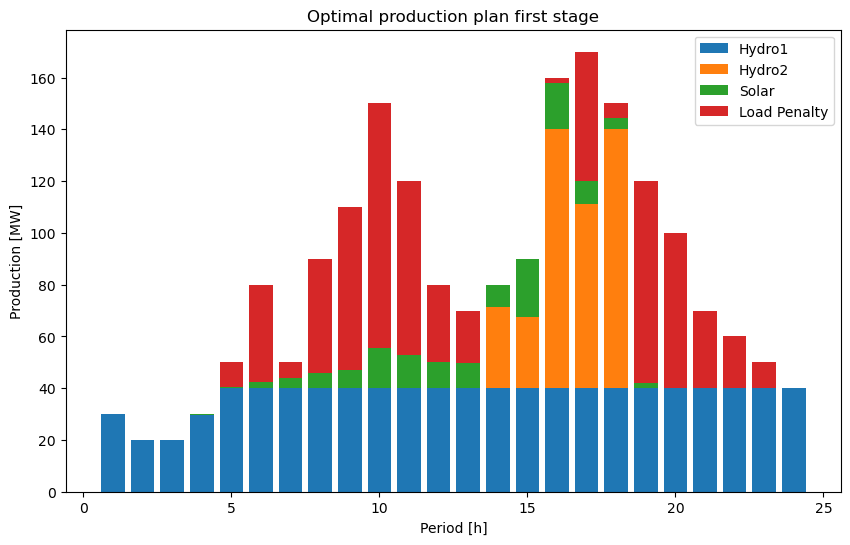

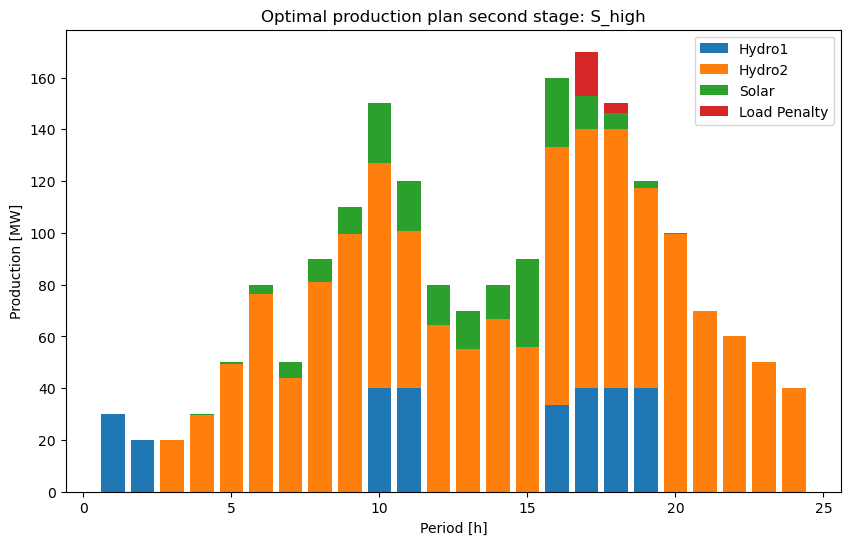

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [5]:
Constants2_1= {
    'Load_penalty':100, 
    'Hydro_cap':3000,
    'Scenarios':['S_high', 'S_avg', 'S_low'], 
    'probs':{'S_high':1, 'S_avg':0, 'S_low':0}     
}
m_high=model_setup(Constants2_1, data)
solve(m_high)
displayresults(m_high)
plotting(m_high)

source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 344 rows, 384 columns and 1296 nonzeros
Model fingerprint: 0x6774cbd1
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [4e+01, 1e+02]
  RHS range        [2e-01, 3e+03]
Presolve removed 327 rows and 333 columns
Presolve time: 0.01s
Presolved: 17 rows, 51 columns, 83 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7116089e+05   1.605063e+02   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
      19    2.2007503e+05   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.200750267e+05
Model unknown

  Variables:
    p : Size=48, Index=p_index

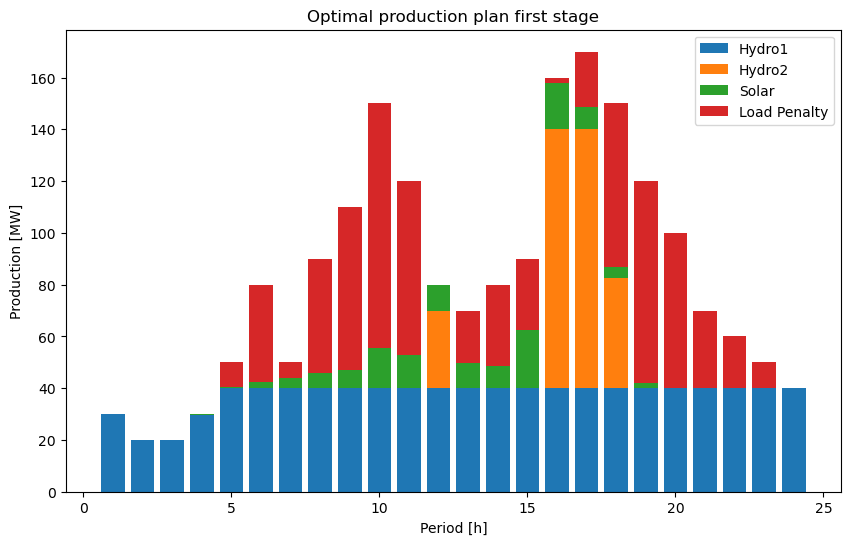

<Figure size 1000x600 with 0 Axes>

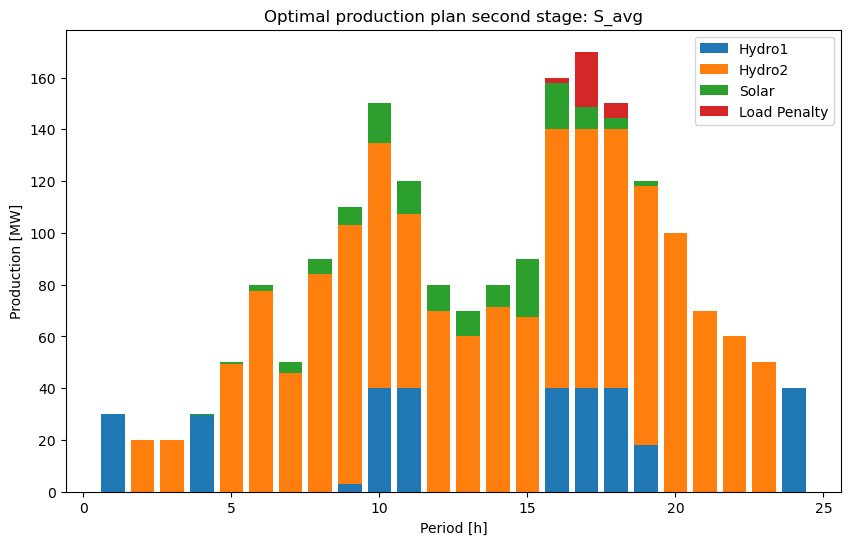

<Figure size 1000x600 with 0 Axes>

In [6]:
Constants2_2= {
    'Load_penalty':100, 
    'Hydro_cap':3000,
    'Scenarios':['S_high', 'S_avg', 'S_low'], 
    'probs':{'S_high':0, 'S_avg':1, 'S_low':0}     
}
m_avg=model_setup(Constants2_2, data)
solve(m_avg)
displayresults(m_avg)
plotting(m_avg)

source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 344 rows, 384 columns and 1296 nonzeros
Model fingerprint: 0xfe0c4bc2
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [4e+01, 1e+02]
  RHS range        [1e-01, 3e+03]
Presolve removed 327 rows and 333 columns
Presolve time: 0.01s
Presolved: 17 rows, 51 columns, 83 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    1.7627938e+05   1.666003e+02   0.000000e+00      0s
      17    2.2836243e+05   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.283624344e+05
Model unknown

  Variables:
    p : Size=48, Index=p_index
        Key            : Lower : Value   

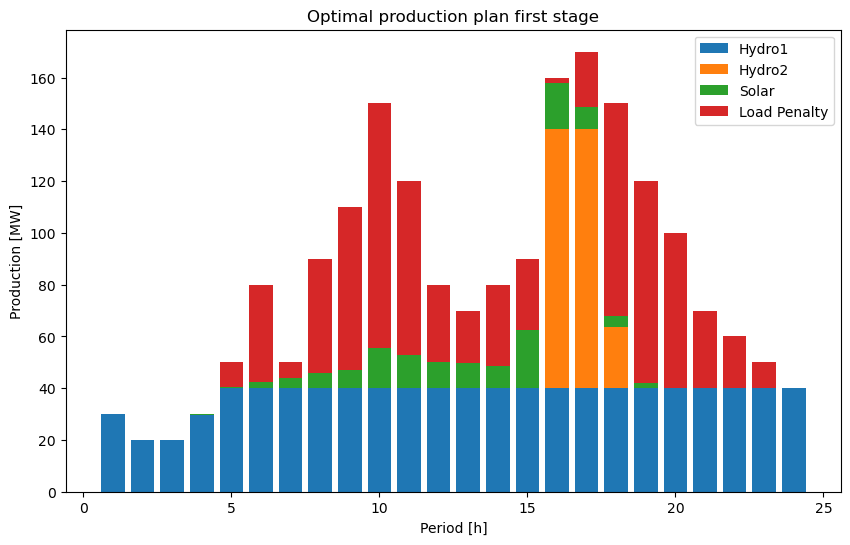

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

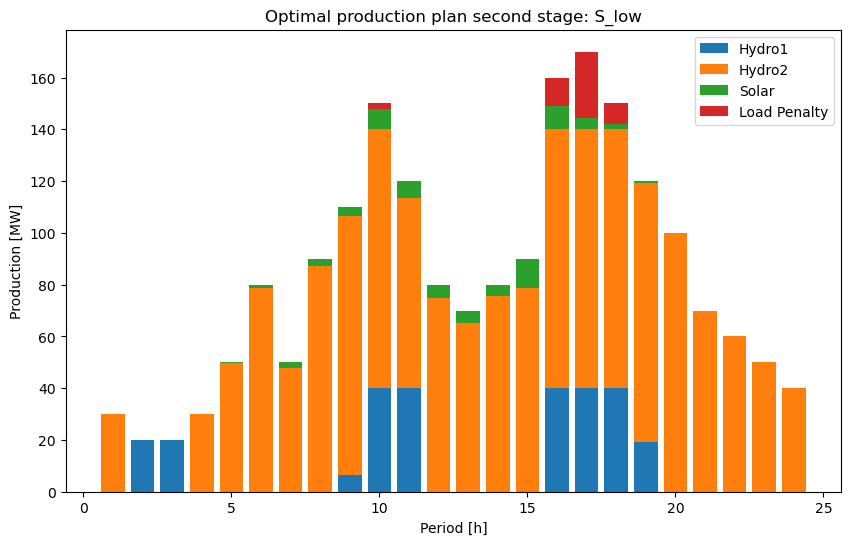

In [7]:
Constants2_3= {
    'Load_penalty':100, 
    'Hydro_cap':3000,
    'Scenarios':['S_high', 'S_avg', 'S_low'], 
    'probs':{'S_high':0, 'S_avg':0, 'S_low':1}     
}
m_low=model_setup(Constants2_3, data)
solve(m_low)
displayresults(m_low)
plotting(m_low)

## Variant 3 (Stochastic optimization problem w/ non-anticipativity)

source (type: set).  This WILL potentially lead to nondeterministic behavior
in Pyomo


Set parameter QCPDual to value 1
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 344 rows, 384 columns and 1296 nonzeros
Model fingerprint: 0x55ea247d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [4e+01, 1e+02]
  RHS range        [1e-01, 3e+03]
Presolve removed 325 rows and 331 columns
Presolve time: 0.01s
Presolved: 19 rows, 53 columns, 153 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.3088578e+05   3.233618e+02   0.000000e+00      0s
Extra simplex iterations after uncrush: 1
      23    2.8296883e+05   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.829688259e+05
Model unknown

  Variables:
    p : Size=48, Index=p_inde

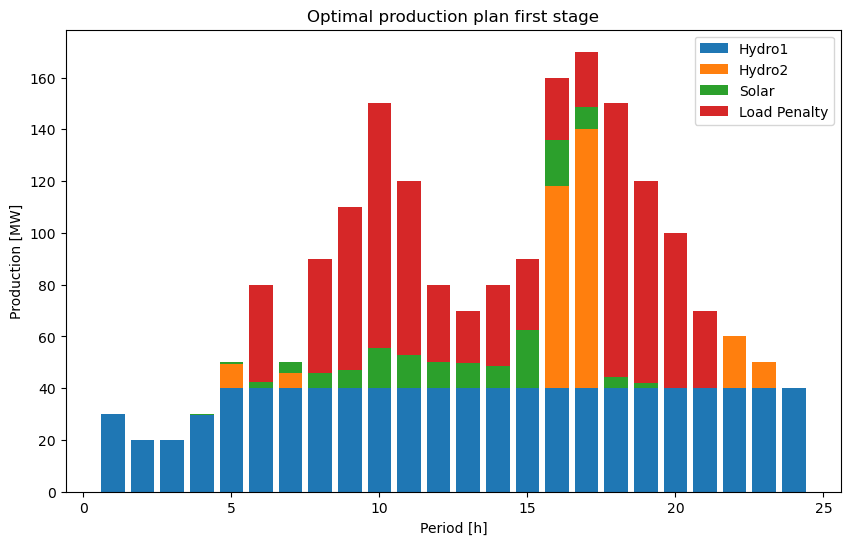

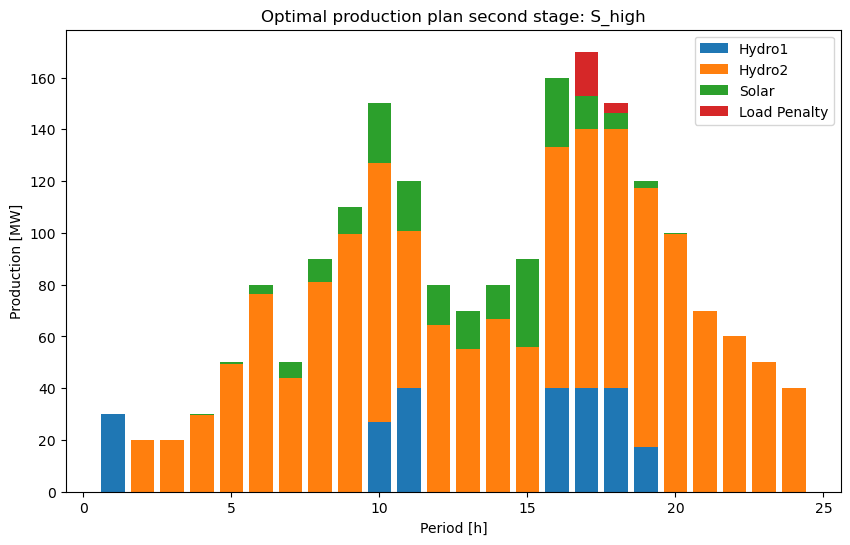

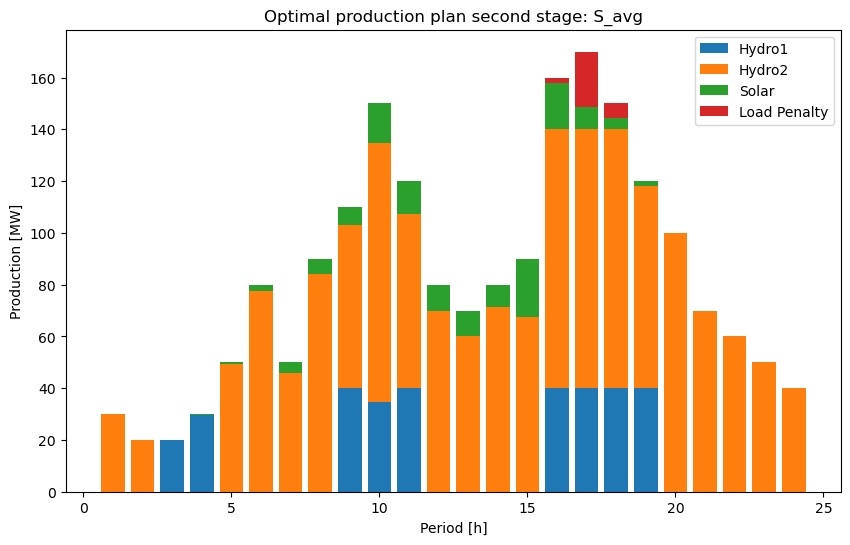

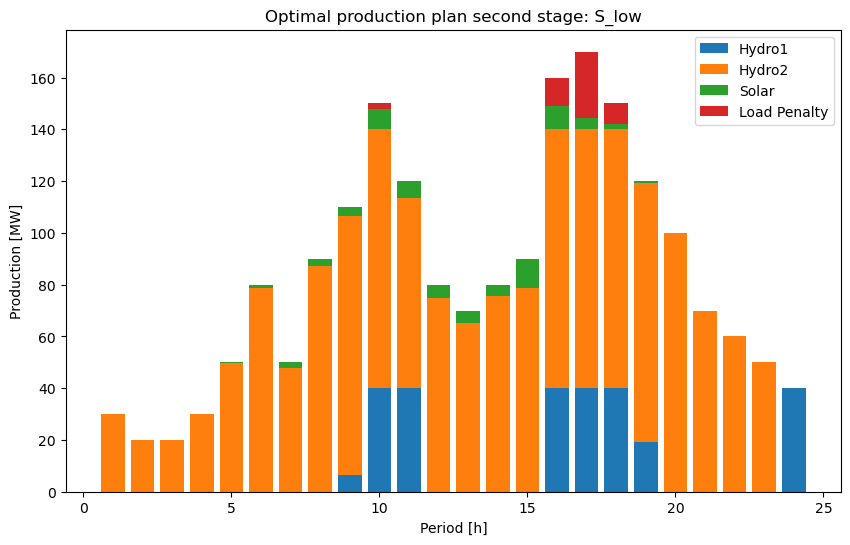

In [9]:
Constants2_3= {
    'Load_penalty':100, 
    'Hydro_cap':3000,
    'Scenarios':['S_high', 'S_avg', 'S_low'], 
    'probs':{'S_high':2/4, 'S_avg':1/2, 'S_low':1/2}     
}
m_stoch=model_setup(Constants2_3, data)
solve(m_stoch)
displayresults(m_stoch)
plotting(m_stoch)